In [ ]:
import os
import kagglehub
# downloaded path from kagglehub
path = kagglehub.dataset_download("msambare/fer2013")
print("path to dataset: ",path)

# Get a list of all files and folders in the downloaded directory
items = os.listdir(path)

# Print the list to see what's inside
print(items)

# checking if an item is a file or a directory
for item in items:
    full_path = os.path.join(path, item)
    if os.path.isdir(full_path):
        print(f"Directory: {item}")
    else:
        print(f"File: {item}")

Using Colab cache for faster access to the 'fer2013' dataset.
path to dataset:  /kaggle/input/fer2013
['test', 'train']
Directory: test
Directory: train


Top-level items in dataset_path: ['test', 'train']
Using folder for class counts/visualization: /kaggle/input/fer2013/train
Found classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  angry        : 3995 images
  disgust      : 436 images
  fear         : 4097 images
  happy        : 7215 images
  neutral      : 4965 images
  sad          : 4830 images
  surprise     : 3171 images

Showing up to 6 random samples (label shown under image):


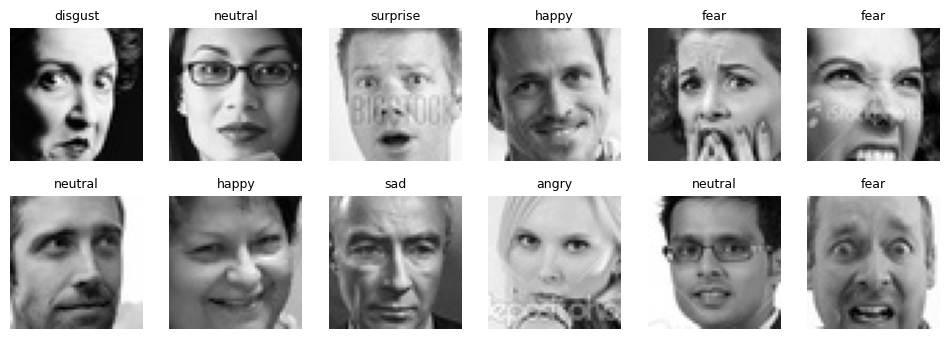

In [ ]:
# Step 1: Inspect dataset structure and visualize up to 6 sample images
import os, random
from PIL import Image
import matplotlib.pyplot as plt

# Ensure 'path' exists from your earlier step
try:
    dataset_path = path
except NameError:
    raise RuntimeError("Variable 'path' not found. Run the dataset download/inspection step first.")

print("Top-level items in dataset_path:", os.listdir(dataset_path))

# Prefer 'train' folder if present
train_dir = os.path.join(dataset_path, "train")
src = train_dir if os.path.isdir(train_dir) else dataset_path
print("Using folder for class counts/visualization:", src)

# List classes (subfolders)
classes = [d for d in sorted(os.listdir(src)) if os.path.isdir(os.path.join(src, d))]
if not classes:
    print("No class subfolders found under", src)
else:
    print("Found classes:", classes)
    for cls in classes:
        cls_path = os.path.join(src, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"  {cls:12s} : {len(imgs)} images")

    # Visualize up to 6 samples
    print("\nShowing up to 6 random samples (label shown under image):")
    samples = []
    for _ in range(12):
        cls = random.choice(classes)
        cls_path = os.path.join(src, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not imgs:
            continue
        img_name = random.choice(imgs)
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('L')  # grayscale
            samples.append((img, cls, img_path))
        except Exception as e:
            print("Failed to open", img_path, e)

    if samples:
        plt.figure(figsize=(12, 4))
        for i, (img, cls, p) in enumerate(samples):
            ax = plt.subplot(2, int(len(samples)/2), i+1)
            plt.imshow(img, cmap='gray')
            plt.title(cls, fontsize=9)
            plt.axis('off')
        plt.show()
    else:
        print("No images available to display.")


In [ ]:
# Step 2: Create PyTorch Dataset & DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms (resize to 48x48, grayscale, tensor, normalize)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),

    # --- Data Augmentation ---
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flips the image horizontally
    transforms.RandomRotation(10),          # Rotates the image by a random degree up to 10
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ), # Applies random translations and scaling

    # --- Standard Pre-processing ---
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Paths
train_dir = os.path.join(dataset_path, "train")
val_dir   = os.path.join(dataset_path, "test")   # or "val" if dataset has it

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir,   transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Quick check
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Classes:", train_dataset.classes)


Train samples: 28709
Val samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# Step 3: Define a simple CNN model in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            # Convolutional Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the size of the flattened features
        # For a 48x48 input, after three 2x2 MaxPool2d layers,
        # the feature map size becomes 6x6.
        self.classifier = nn.Sequential(
            nn.Dropout(0.6), # Add a dropout layer for regularization
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.classifier(x)
        return x

# Instantiate model
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)

print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=T

In [ ]:
# Step 4: Set up training utilities
import torch.optim as optim

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


In [ ]:
from torchsummary import summary

summary(model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 24, 24]          73,856
       BatchNorm2d-6          [-1, 128, 24, 24]             256
              ReLU-7          [-1, 128, 24, 24]               0
         MaxPool2d-8          [-1, 128, 12, 12]               0
            Conv2d-9          [-1, 256, 12, 12]         295,168
      BatchNorm2d-10          [-1, 256, 12, 12]             512
             ReLU-11          [-1, 256, 12, 12]               0
        MaxPool2d-12            [-1, 256, 6, 6]               0
          Dropout-13                 [-1, 9216]               0
           Linear-14                  [

In [ ]:
# Step 5: Training + Validation Loop
EPOCHS = 50
# Initialize the GradScaler for Mixed Precision training
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    # Add persistent_workers for faster data loading
    # we must also set num_workers > 0 in your DataLoader.
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Use autocast for automatic mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scales loss, so the gradients don't underflow
        scaler.scale(loss).backward()

        # Scales back and performs the optimization step
        scaler.step(optimizer)

        # Updates the scale for the next iteration
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            # Mixed precision is also applied during validation for faster inference
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

/tmp/ipython-input-2218363792.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-2218363792.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2218363792.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/50 | Train Loss: 1.6448, Train Acc: 34.15% | Val Loss: 1.4617, Val Acc: 43.79%
Epoch 2/50 | Train Loss: 1.6050, Train Acc: 36.40% | Val Loss: 1.4331, Val Acc: 44.72%
Epoch 3/50 | Train Loss: 1.5773, Train Acc: 37.52% | Val Loss: 1.4136, Val Acc: 45.44%
Epoch 4/50 | Train Loss: 1.5494, Train Acc: 38.79% | Val Loss: 1.3842, Val Acc: 45.83%
Epoch 5/50 | Train Loss: 1.5331, Train Acc: 39.39% | Val Loss: 1.3690, Val Acc: 47.23%
Epoch 6/50 | Train Loss: 1.5121, Train Acc: 40.63% | Val Loss: 1.3373, Val Acc: 47.97%
Epoch 7/50 | Train Loss: 1.5020, Train Acc: 41.08% | Val Loss: 1.3463, Val Acc: 48.73%
Epoch 8/50 | Train Loss: 1.4897, Train Acc: 41.05% | Val Loss: 1.3141, Val Acc: 48.98%
Epoch 9/50 | Train Loss: 1.4766, Train Acc: 42.36% | Val Loss: 1.2993, Val Acc: 49.83%
Epoch 10/50 | Train Loss: 1.4620, Train Acc: 42.38% | Val Loss: 1.2780, Val Acc: 51.10%
Epoch 11/50 | Train Loss: 1.4541, Train Acc: 43.09% | Val Loss: 1.2778, Val Acc: 50.45%
Epoch 12/50 | Train Loss: 1.4501, Train A

In [ ]:
# Step 6: Evaluate on validation set
model.eval()
val_correct, val_total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy = 100 * val_correct / val_total
print(f"Final Validation Accuracy: {val_accuracy:.2f}%")


Final Validation Accuracy: 62.05%


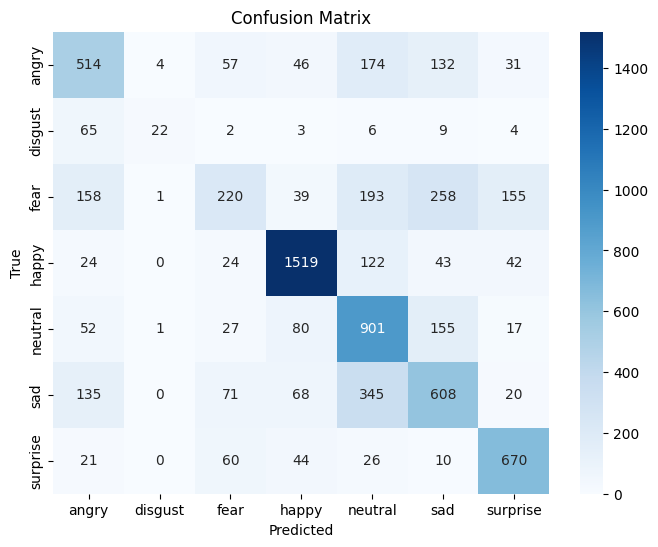


Classification Report:

              precision    recall  f1-score   support

       angry      0.530     0.537     0.533       958
     disgust      0.786     0.198     0.317       111
        fear      0.477     0.215     0.296      1024
       happy      0.844     0.856     0.850      1774
     neutral      0.510     0.731     0.601      1233
         sad      0.500     0.488     0.494      1247
    surprise      0.714     0.806     0.757       831

    accuracy                          0.621      7178
   macro avg      0.623     0.547     0.550      7178
weighted avg      0.617     0.621     0.605      7178



In [ ]:
# Step 7: Confusion Matrix and Classification Report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes, digits=3))


## using transfer learning

In [ ]:
import torchvision.models as models

# Load ResNet18 pretrained on ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
print(resnet18)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Modify the final fully connected layer for 7 classes
num_classes = 7
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Unfreeze all layers of the model for fine-tuning
# By default, requires_grad is True for all parameters
for param in resnet18.parameters():
    param.requires_grad = True

# Check trainable vs non-trainable parameters after unfreezing
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in resnet18.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Trainable parameters: 11180103
Non-trainable parameters: 0


In [ ]:
# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Unfreeze only the final fully connected layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Check params again
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in resnet18.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Trainable parameters: 513000
Non-trainable parameters: 11176512


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define the paths to your dataset directories
train_dir = '/kaggle/input/fer2013/train'
val_dir = '/kaggle/input/fer2013/test'

# Define the transforms for training data, including on-the-fly data augmentation
train_transform = transforms.Compose([
    # Convert single-channel grayscale to 3 channels for pre-trained models
    transforms.Grayscale(num_output_channels=3),
    # Resize to the standard input size for models like ResNet
    transforms.Resize((224, 224)),

    # Data Augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    # Note: ColorJitter won't affect saturation on a grayscale image
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),

    # Standard Pre-processing
    transforms.ToTensor(),
    # Normalize with standard ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the transforms for validation data (no random augmentation)
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use the new pipelines to create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

# Create data loaders with performance optimizations
# Set num_workers to 0 and persistent_workers to False to avoid DataLoader multiprocessing issues
NUM_WORKERS = 0
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=NUM_WORKERS,
    persistent_workers=False # Set to False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=NUM_WORKERS,
    persistent_workers=False # Set to False
)

In [ ]:
# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

resnet50 = resnet18.to(device)


Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

# Load the ResNet-18 model with pre-trained weights
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the final layer for 7 emotion classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 7)

# Assuming train_loader, val_loader, and device are already defined

# Move model to device
resnet18 = resnet18.to(device) # Reverted .half() here

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer for the entire model (parameters should be in FP32)
optimizer = optim.Adam(resnet18.parameters(), lr=1e-5)


# Learning rate scheduler: reduces LR when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# GradScaler for mixed-precision training
scaler = torch.cuda.amp.GradScaler()

# Number of epochs and early stopping parameters
num_epochs = 50
best_val_loss = float('inf')
patience_counter = 0
patience = 7

# Path to save the best model
model_path = 'best_model.pth'

for epoch in range(num_epochs):
    # TRAINING LOOP
    resnet18.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed-precision training: autocast and scaler
        with torch.cuda.amp.autocast():
            outputs = resnet18(inputs.float()) # Ensure inputs are float within autocast
            loss = criterion(outputs.float(), labels) # Ensure outputs are float for loss computation

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data.float(), 1) # Ensure predictions are from float outputs
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # VALIDATION LOOP
    resnet18.eval()
    correct_val, total_val, val_loss = 0, 0, 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = resnet18(inputs.float()) # Ensure inputs are float within autocast
                loss = criterion(outputs.float(), labels) # Ensure outputs are float for loss computation


            val_loss += loss.item()

            _, predicted = torch.max(outputs.data.float(), 1) # Ensure predictions are from float outputs
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(val_loader)

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # MODEL CHECKPOINTING & EARLY STOPPING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(resnet18.state_dict(), model_path)
        print("Model improved! Saving checkpoint.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.")
        break

/tmp/ipython-input-1907088132.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1907088132.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1907088132.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50] - Train Loss: 1.5205, Train Acc: 41.64% | Val Loss: 1.2899, Val Acc: 51.10%
Model improved! Saving checkpoint.
Epoch [2/50] - Train Loss: 1.2194, Train Acc: 54.19% | Val Loss: 1.1465, Val Acc: 56.48%
Model improved! Saving checkpoint.
Epoch [3/50] - Train Loss: 1.1188, Train Acc: 58.24% | Val Loss: 1.0875, Val Acc: 58.39%
Model improved! Saving checkpoint.
Epoch [4/50] - Train Loss: 1.0578, Train Acc: 60.42% | Val Loss: 1.0456, Val Acc: 60.52%
Model improved! Saving checkpoint.
Epoch [5/50] - Train Loss: 1.0159, Train Acc: 62.31% | Val Loss: 1.0177, Val Acc: 61.05%
Model improved! Saving checkpoint.
Epoch [6/50] - Train Loss: 0.9766, Train Acc: 63.73% | Val Loss: 0.9923, Val Acc: 62.61%
Model improved! Saving checkpoint.
Epoch [7/50] - Train Loss: 0.9495, Train Acc: 64.53% | Val Loss: 0.9803, Val Acc: 62.76%
Model improved! Saving checkpoint.
Epoch [8/50] - Train Loss: 0.9233, Train Acc: 65.55% | Val Loss: 0.9641, Val Acc: 63.93%
Model improved! Saving checkpoint.
Epoch [9

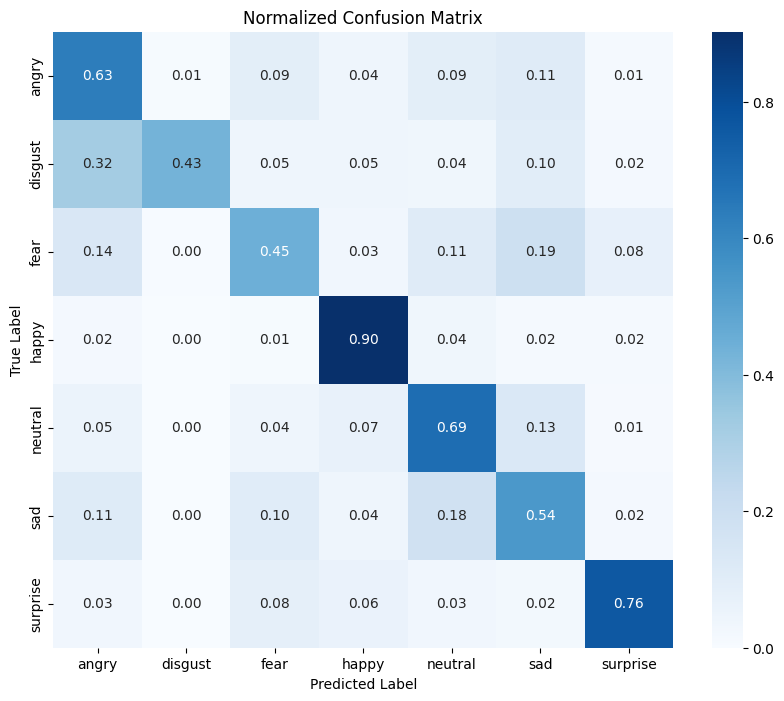

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'resnet18' and 'val_loader' are already defined
# Make sure your classes are in a consistent order
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Place this code after your validation loop finishes
all_preds = []
all_labels = []

resnet18.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix by row (divide by the sum of each row)
# This will show the percentage of predictions for each true label
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()
